In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Load dataset
df = pd.read_csv('../data/final_dataset.csv')
print(f"Loaded {len(df)} posts from {df['user_id'].nunique()} users")
print(f"\nSample post:\n{df['post_text'].iloc[0][:300]}...")

Loaded 78530 posts from 2558 users

Sample post:
Please someone answer quickly

Hello
I just had a thought pop up last night about what if I am attracted to animals?
It really made me disgusted and I have experienced OCD before, but I recently recovered. I dont feel much anxiety, but I feel uncomfortable and disgusted each time a image has popped ...


In [3]:
# Absolutist words (linked to anxiety, depression, suicidal ideation)
ABSOLUTIST_WORDS = {
    'always', 'never', 'nothing', 'everything', 'completely', 'totally',
    'absolutely', 'entirely', 'constantly', 'forever', 'impossible',
    'definitely', 'certainly', 'wholly', 'utterly', 'all', 'none',
    'every', 'no one', 'everyone', 'nobody', 'everybody'
}

# Negative emotion words
NEGATIVE_WORDS = {
    'sad', 'depressed', 'anxious', 'worried', 'afraid', 'scared', 'angry',
    'frustrated', 'hopeless', 'worthless', 'useless', 'terrible', 'awful',
    'horrible', 'miserable', 'lonely', 'alone', 'empty', 'numb', 'exhausted',
    'tired', 'overwhelmed', 'stressed', 'panic', 'fear', 'hate', 'crying',
    'tears', 'pain', 'hurt', 'suffering', 'struggling', 'failed', 'failure',
    'broken', 'damaged', 'lost', 'confused', 'helpless', 'desperate'
}

# Crisis/urgency words
CRISIS_WORDS = {
    'suicide', 'suicidal', 'kill myself', 'end it', 'give up', 'cant go on',
    "can't go on", 'no point', 'want to die', 'better off dead', 'end my life',
    'self harm', 'self-harm', 'cutting', 'overdose', 'pills'
}

# Cognitive distortion words (all-or-nothing thinking)
DISTORTION_WORDS = {
    'should', 'must', 'have to', 'need to', 'cant', "can't", 'wont', "won't",
    'ruined', 'disaster', 'catastrophe', 'worst', 'never going to'
}

# First person singular (high usage linked to depression)
FIRST_PERSON = {'i', 'me', 'my', 'myself', 'mine', "i'm", "i've", "i'll", "i'd"}

print("Linguistic markers defined!")
print(f"  Absolutist words: {len(ABSOLUTIST_WORDS)}")
print(f"  Negative words: {len(NEGATIVE_WORDS)}")
print(f"  Crisis words: {len(CRISIS_WORDS)}")
print(f"  Distortion words: {len(DISTORTION_WORDS)}")
print(f"  First person: {len(FIRST_PERSON)}")

Linguistic markers defined!
  Absolutist words: 22
  Negative words: 40
  Crisis words: 16
  Distortion words: 13
  First person: 9


In [ ]:
def calculate_linguistic_risk(text):
    """
    Calculate risk score (0-100) based on linguistic markers.
    Higher score = more distress signals detected.
    """
    if not text or not isinstance(text, str):
        return {'risk_score': 0, 'components': {}}
    
    # Preprocess
    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)
    word_count = len(words) if words else 1  # Avoid division by zero
    
    # Count markers
    absolutist_count = sum(1 for w in words if w in ABSOLUTIST_WORDS)
    negative_count = sum(1 for w in words if w in NEGATIVE_WORDS)
    first_person_count = sum(1 for w in words if w in FIRST_PERSON)
    distortion_count = sum(1 for w in words if w in DISTORTION_WORDS)
    
    # crisis phrases (weighted heavily)
    crisis_count = sum(1 for phrase in CRISIS_WORDS if phrase in text_lower)
    
    # Calculate component scores (normalized per 100 words)
    normalize = 100 / word_count
    
    components = {
        'absolutist': min(absolutist_count * normalize * 3, 20),      # Max 20 points
        'negative_emotion': min(negative_count * normalize * 2, 25),  # Max 25 points
        'first_person': min(first_person_count * normalize * 1, 15),  # Max 15 points
        'cognitive_distortion': min(distortion_count * normalize * 3, 20),  # Max 20 points
        'crisis_language': min(crisis_count * 10, 20)                 # Max 20 points
    }
    
    # Total risk score (0-100)
    risk_score = sum(components.values())
    
    # Detected words for explainability
    detected = {
        'absolutist': [w for w in words if w in ABSOLUTIST_WORDS],
        'negative': [w for w in words if w in NEGATIVE_WORDS],
        'crisis': [p for p in CRISIS_WORDS if p in text_lower]
    }
    
    return {
        'risk_score': round(risk_score, 1),
        'components': components,
        'detected_words': detected,
        'word_count': word_count
    }

# Test it
test_texts = [
    "I had a pretty good day today, feeling okay.",
    "I'm feeling a bit anxious about my exam tomorrow.",
    "I always feel like nothing matters. I'm completely worthless and hopeless.",
    "I can't do this anymore. Everything is terrible and I just want to give up."
]

print("=" * 70)
print("LINGUISTIC RISK SCORE EXAMPLES")
print("=" * 70)

for text in test_texts:
    result = calculate_linguistic_risk(text)
    print(f"\nText: \"{text[:60]}...\"" if len(text) > 60 else f"\nText: \"{text}\"")
    print(f"Risk Score: {result['risk_score']}/100")
    print(f"Components: {result['components']}")

LINGUISTIC RISK SCORE EXAMPLES

Text: "I had a pretty good day today, feeling okay."
Risk Score: 11.1/100
Components: {'absolutist': 0.0, 'negative_emotion': 0.0, 'first_person': 11.11111111111111, 'cognitive_distortion': 0.0, 'crisis_language': 0}

Text: "I'm feeling a bit anxious about my exam tomorrow."
Risk Score: 35.0/100
Components: {'absolutist': 0.0, 'negative_emotion': 20.0, 'first_person': 15, 'cognitive_distortion': 0.0, 'crisis_language': 0}

Text: "I always feel like nothing matters. I'm completely worthless..."
Risk Score: 60.0/100
Components: {'absolutist': 20, 'negative_emotion': 25, 'first_person': 15, 'cognitive_distortion': 0.0, 'crisis_language': 0}

Text: "I can't do this anymore. Everything is terrible and I just w..."
Risk Score: 53.8/100
Components: {'absolutist': 18.75, 'negative_emotion': 12.5, 'first_person': 12.5, 'cognitive_distortion': 0.0, 'crisis_language': 10}


In [ ]:
# risk scores for all posts
print("Calculating risk scores for all posts...")

risk_results = df['post_text'].apply(calculate_linguistic_risk)

# Check for any issues
print(f"Sample result: {risk_results.iloc[0]}")

# Extract scores safely with default values
df['risk_score'] = risk_results.apply(lambda x: x.get('risk_score', 0))
df['absolutist_score'] = risk_results.apply(lambda x: x.get('components', {}).get('absolutist', 0))
df['negative_score'] = risk_results.apply(lambda x: x.get('components', {}).get('negative_emotion', 0))
df['first_person_score'] = risk_results.apply(lambda x: x.get('components', {}).get('first_person', 0))
df['distortion_score'] = risk_results.apply(lambda x: x.get('components', {}).get('cognitive_distortion', 0))
df['crisis_score'] = risk_results.apply(lambda x: x.get('components', {}).get('crisis_language', 0))

print("Done!")
print(f"\nRisk Score Statistics:")
print(df['risk_score'].describe())

Calculating risk scores for all posts...
Sample result: {'risk_score': 16.4, 'components': {'absolutist': 0.9259259259259258, 'negative_emotion': 2.4691358024691357, 'first_person': 12.962962962962962, 'cognitive_distortion': 0.0, 'crisis_language': 0}, 'detected_words': {'absolutist': ['all'], 'negative': ['afraid', 'worried', 'anxious', 'anxious'], 'crisis': []}, 'word_count': 324}
Done!

Risk Score Statistics:
count    78530.000000
mean         5.140521
std          8.857520
min          0.000000
25%          0.000000
50%          0.000000
75%         10.300000
max         75.000000
Name: risk_score, dtype: float64


AVERAGE RISK SCORE BY CONDITION
                mean    std  median
primary_label                      
depression     17.96  13.75    18.3
ptsd           15.04   9.26    15.0
aspergers      11.36   8.40    11.8
ADHD           11.36   8.36    12.5
OCD             3.35   7.60     0.0


/var/folders/zc/j2kbnvw90wsf40z_rnt6q41c0000gn/T/ipykernel_19463/4122175573.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='primary_label', y='risk_score', order=order, ax=axes[0], palette='Reds')


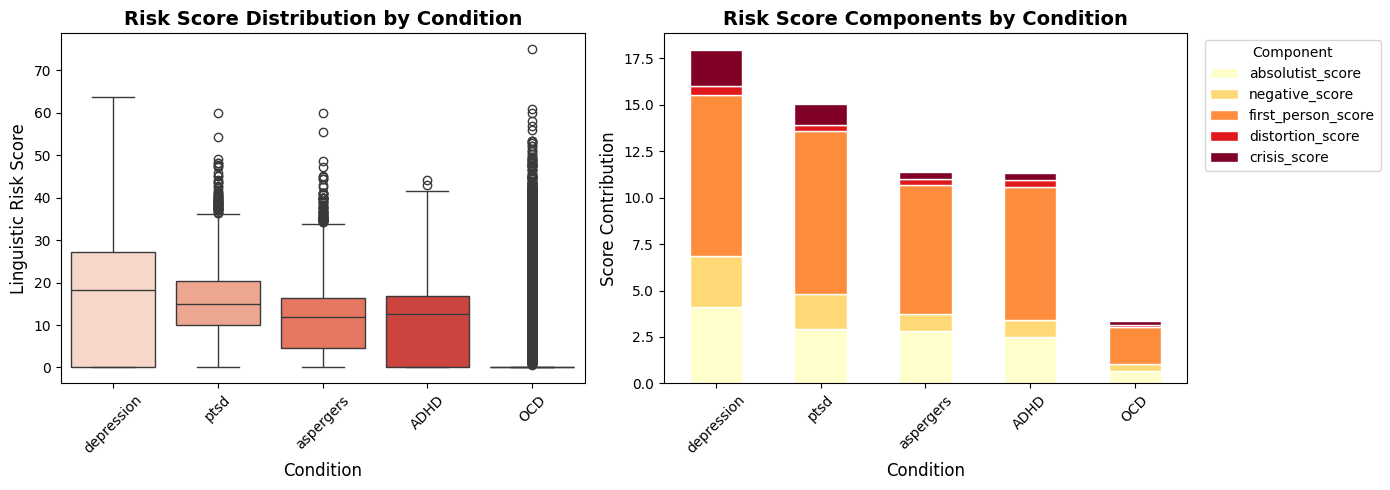


✓ Saved: results/risk_scores_by_condition.png


In [7]:
# Average risk score by condition
risk_by_condition = df.groupby('primary_label')['risk_score'].agg(['mean', 'std', 'median'])
risk_by_condition = risk_by_condition.sort_values('mean', ascending=False)

print("=" * 70)
print("AVERAGE RISK SCORE BY CONDITION")
print("=" * 70)
print(risk_by_condition.round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
order = risk_by_condition.index.tolist()
sns.boxplot(data=df, x='primary_label', y='risk_score', order=order, ax=axes[0], palette='Reds')
axes[0].set_title('Risk Score Distribution by Condition', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Condition', fontsize=12)
axes[0].set_ylabel('Linguistic Risk Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Component breakdown
component_cols = ['absolutist_score', 'negative_score', 'first_person_score', 
                  'distortion_score', 'crisis_score']
component_means = df.groupby('primary_label')[component_cols].mean()
component_means = component_means.loc[order]

component_means.plot(kind='bar', stacked=True, ax=axes[1], 
                     colormap='YlOrRd', edgecolor='white')
axes[1].set_title('Risk Score Components by Condition', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Condition', fontsize=12)
axes[1].set_ylabel('Score Contribution', fontsize=12)
axes[1].legend(title='Component', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/risk_scores_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: results/risk_scores_by_condition.png")

RISK LEVEL DISTRIBUTION BY CONDITION (%)
risk_level      Low  Moderate  Elevated  High
primary_label                                
ADHD           64.0      34.6       1.4   0.0
OCD            88.4      10.3       1.3   0.0
aspergers      66.1      31.6       2.3   0.0
depression     38.2      42.4      18.1   1.3
ptsd           48.8      45.7       5.4   0.1


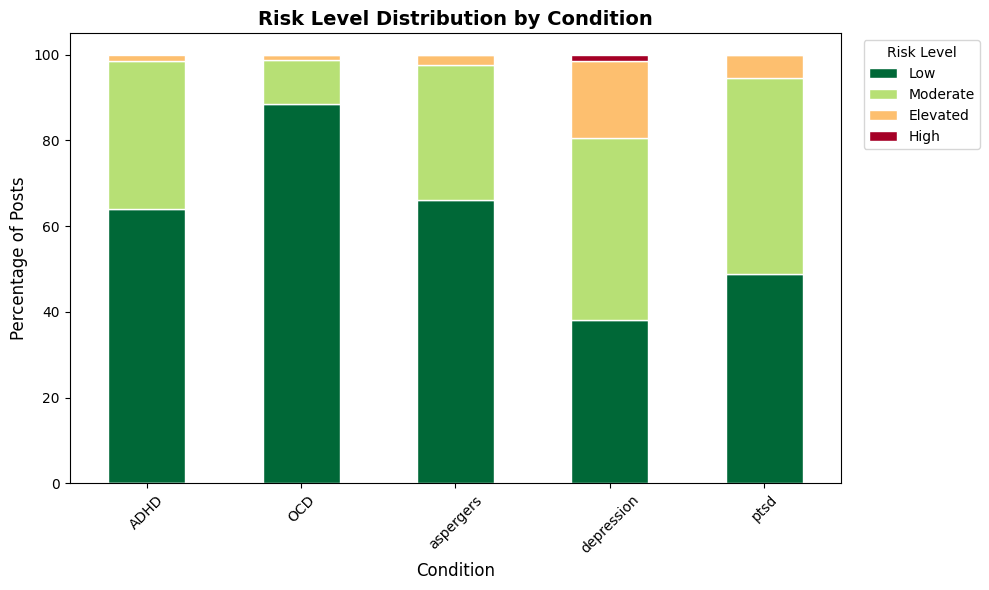


✓ Saved: results/risk_levels_by_condition.png


In [ ]:
def get_risk_level(score):
    """Categorize risk score into levels"""
    if score < 15:
        return 'Low'
    elif score < 30:
        return 'Moderate'
    elif score < 50:
        return 'Elevated'
    else:
        return 'High'

df['risk_level'] = df['risk_score'].apply(get_risk_level)

# risk levels by condition
risk_level_dist = pd.crosstab(df['primary_label'], df['risk_level'], normalize='index') * 100
risk_level_dist = risk_level_dist[['Low', 'Moderate', 'Elevated', 'High']]

print("=" * 70)
print("RISK LEVEL DISTRIBUTION BY CONDITION (%)")
print("=" * 70)
print(risk_level_dist.round(1))

# Visualize
risk_level_dist.plot(kind='bar', stacked=True, figsize=(10, 6), 
                     colormap='RdYlGn_r', edgecolor='white')
plt.title('Risk Level Distribution by Condition', fontsize=14, fontweight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Percentage of Posts', fontsize=12)
plt.legend(title='Risk Level', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/risk_levels_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: results/risk_levels_by_condition.png")

In [9]:
# Save updated dataset
df.to_csv('../data/dataset_with_risk_scores.csv', index=False)
print("✓ Saved: data/dataset_with_risk_scores.csv")

# Save the risk calculation function for Streamlit
risk_module = '''
import re

ABSOLUTIST_WORDS = {
    'always', 'never', 'nothing', 'everything', 'completely', 'totally',
    'absolutely', 'entirely', 'constantly', 'forever', 'impossible',
    'definitely', 'certainly', 'wholly', 'utterly', 'all', 'none',
    'every', 'no one', 'everyone', 'nobody', 'everybody'
}

NEGATIVE_WORDS = {
    'sad', 'depressed', 'anxious', 'worried', 'afraid', 'scared', 'angry',
    'frustrated', 'hopeless', 'worthless', 'useless', 'terrible', 'awful',
    'horrible', 'miserable', 'lonely', 'alone', 'empty', 'numb', 'exhausted',
    'tired', 'overwhelmed', 'stressed', 'panic', 'fear', 'hate', 'crying',
    'tears', 'pain', 'hurt', 'suffering', 'struggling', 'failed', 'failure',
    'broken', 'damaged', 'lost', 'confused', 'helpless', 'desperate'
}

CRISIS_WORDS = {
    'suicide', 'suicidal', 'kill myself', 'end it', 'give up', 'cant go on',
    "can't go on", 'no point', 'want to die', 'better off dead', 'end my life',
    'self harm', 'self-harm', 'cutting', 'overdose', 'pills'
}

DISTORTION_WORDS = {
    'should', 'must', 'have to', 'need to', 'cant', "can't", 'wont', "won't",
    'ruined', 'disaster', 'catastrophe', 'worst', 'never going to'
}

FIRST_PERSON = {'i', 'me', 'my', 'myself', 'mine', "i'm", "i've", "i'll", "i'd"}

def calculate_linguistic_risk(text):
    if not text or not isinstance(text, str):
        return {'risk_score': 0, 'components': {}, 'detected_words': {}, 'word_count': 0}
    
    text_lower = text.lower()
    words = re.findall(r'\\b\\w+\\b', text_lower)
    word_count = len(words) if words else 1
    
    absolutist_count = sum(1 for w in words if w in ABSOLUTIST_WORDS)
    negative_count = sum(1 for w in words if w in NEGATIVE_WORDS)
    first_person_count = sum(1 for w in words if w in FIRST_PERSON)
    distortion_count = sum(1 for w in words if w in DISTORTION_WORDS)
    crisis_count = sum(1 for phrase in CRISIS_WORDS if phrase in text_lower)
    
    normalize = 100 / word_count
    
    components = {
        'absolutist': min(absolutist_count * normalize * 3, 20),
        'negative_emotion': min(negative_count * normalize * 2, 25),
        'first_person': min(first_person_count * normalize * 1, 15),
        'cognitive_distortion': min(distortion_count * normalize * 3, 20),
        'crisis_language': min(crisis_count * 10, 20)
    }
    
    risk_score = sum(components.values())
    
    detected = {
        'absolutist': [w for w in words if w in ABSOLUTIST_WORDS],
        'negative': [w for w in words if w in NEGATIVE_WORDS],
        'crisis': [p for p in CRISIS_WORDS if p in text_lower]
    }
    
    return {
        'risk_score': round(risk_score, 1),
        'components': components,
        'detected_words': detected,
        'word_count': word_count
    }

def get_risk_level(score):
    if score < 15:
        return 'Low', '🟢'
    elif score < 30:
        return 'Moderate', '🟡'
    elif score < 50:
        return 'Elevated', '🟠'
    else:
        return 'High', '🔴'
'''

with open('../src/risk_calculator.py', 'w') as f:
    f.write(risk_module)

# Create src directory if needed
import os
os.makedirs('../src', exist_ok=True)

with open('../src/risk_calculator.py', 'w') as f:
    f.write(risk_module)
    
with open('../src/__init__.py', 'w') as f:
    f.write('')

print("✓ Saved: src/risk_calculator.py")
print("\n" + "=" * 70)
print("STEP 1 COMPLETE: Linguistic Risk Signals")
print("=" * 70)

✓ Saved: data/dataset_with_risk_scores.csv
✓ Saved: src/risk_calculator.py

STEP 1 COMPLETE: Linguistic Risk Signals
